In [1]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

In [2]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/durnjstkwls.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)

(531, 413, 3)


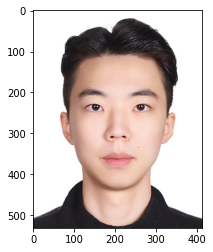

In [3]:
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)) # opencv는 BGR로 받아들이니까 plt에서 나타낼려면 RGB로 바꿔줘야합니다.
plt.show()

In [4]:
# 1
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
# 2
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file) 

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7e4cb6f199d0>)

In [5]:
model = semantic_segmentation() #PixelLib 라이브러리 에서 가져온 클래스를 가져와서 semantic segmentation을 수행하는 클래스 인스턴스를 만듬
model.load_pascalvoc_model(model_file) # pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출

In [6]:
segvalues, output = model.segmentAsPascalvoc(img_path) # segmentAsPascalvoc()함 수 를 호출 하여 입력된 이미지를 분할, 분할 출력의 배열을 가져옴, 분할 은 pacalvoc 데이터로 학습된 모델을 이용

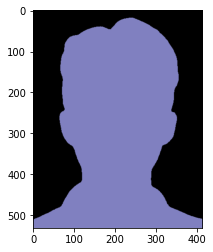

In [7]:
#segmentAsPascalvoc() 함수 를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 output을 matplotlib을 이용해 출력
plt.imshow(output)
plt.show()

In [8]:
segvalues # segmentAsPascalvoc() 함수를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 배열값을 출력
# LABEL_NAMES를 보면 15번째가 사람('person')

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]])}

In [10]:
#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

In [11]:
#segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


In [12]:
#컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [13]:
colormap[15] #컬러맵 15에 해당하는 배열 출력 (index 15가 'person'입니다.)

array([192, 128, 128])

In [14]:
seg_color = (128,128,192) # 색상순서 변경 - colormap의 배열은 RGB 순이며 output의 배열은 BGR 순서로 채널 배치가 되어 있습니다.

(531, 413)


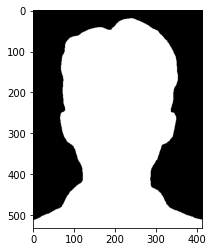

In [15]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다.
# seg_color 값이 person을 값이 므로 사람이 있는 위치를 제외하고는 gray로 출력합니다.
# cmap 값을 변경하면 다른 색상으로 확인이 가능합니다.
seg_map = np.all(output == seg_color, axis = -1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap = 'gray')
plt.show()

# 3채널을 가졌던 원본과는 다르게 채널 정보가 사라진 것을 확인할 수 있습니다.

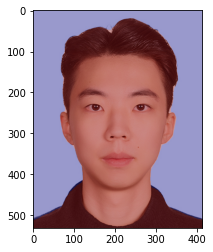

In [16]:
# 원본이미지와 겹쳐보면서 잘 되었는지 알아봅시다.
# 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

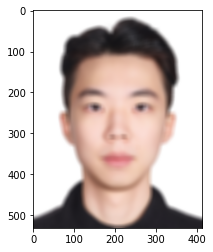

In [17]:
# (13,13)은 blurring kernel size를 뜻합니다.
img_orig_blur = cv2.blur(img_orig, (13,13))

plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

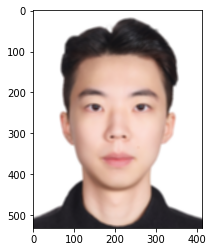

In [18]:
# (7,7)로 바꿔보기
img_orig_blur = cv2.blur(img_orig, (7,7))

plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

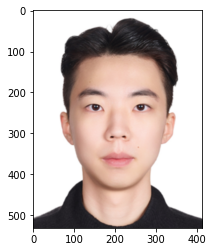

In [19]:
# (3,3)로 바꿔보기
img_orig_blur = cv2.blur(img_orig, (3,3))

plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

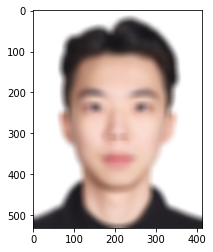

In [20]:
# (19,19)로 바꿔보기
img_orig_blur = cv2.blur(img_orig, (19,19))

plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

# blurring kernel의 size를 키우면 키울수록 더욱 blurring이 심하고 
# 낮출수록 원본이미지와 비슷한 수준을 가지는 것을 확인할 수 있습니다.

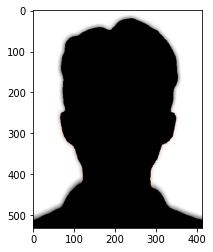

In [21]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR) # 원본이 BGR로 읽으니 색상 채널을 변경할 때는 먼저 BGR로 바꿔줘야합니다.

# cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 사람이 255 였으나 연산을 하고 나면 배경은 255 사람은 0입니다.
img_bg_mask = cv2.bitwise_not(img_mask_color)

# cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 
# 즉, 사람이 사라지고 배경만 남게됩니다.

img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

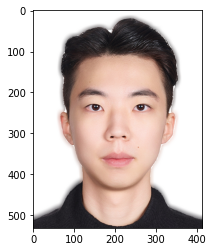

In [22]:
img_concat = np.where(img_mask_color == 255, img_orig, img_bg_blur) # np.where을 사용해서 마스크 255인 부분의 값만 들고오도록 합니다.

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

- 흰색 배경이랑 닿이는 부분은 잘 못 잡는 것처럼 보입니다.
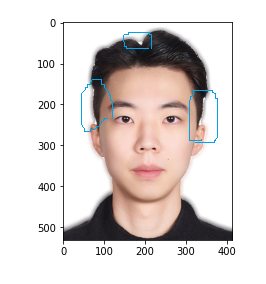

## 고양이

In [25]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/catcat.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)

(528, 640, 3)


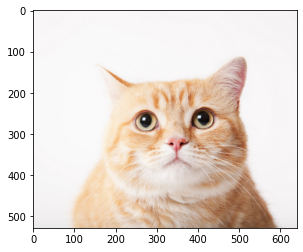

In [26]:
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)) # opencv는 BGR로 받아들이니까 plt에서 나타낼려면 RGB로 바꿔줘야합니다.
plt.show()

In [27]:
model = semantic_segmentation() 
model.load_pascalvoc_model(model_file) 
segvalues, output = model.segmentAsPascalvoc(img_path)

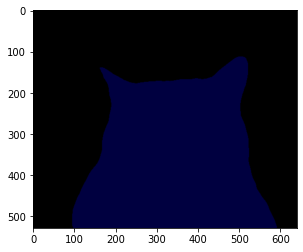

In [28]:
plt.imshow(output)
plt.show()

In [29]:
segvalues

{'class_ids': array([0, 8]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [31]:
colormap[8]

array([64,  0,  0])

In [39]:
seg_color = (0,0,64)

(528, 640)


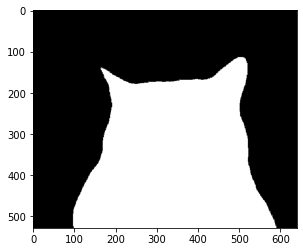

In [40]:
seg_map = np.all(output == seg_color, axis = -1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap = 'gray')
plt.show()

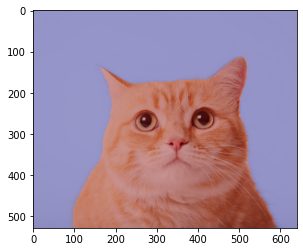

In [41]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

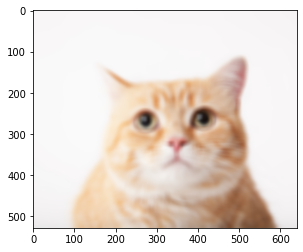

In [42]:
img_orig_blur = cv2.blur(img_orig, (13,13))

plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

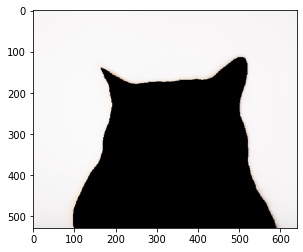

In [43]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR) 

img_bg_mask = cv2.bitwise_not(img_mask_color)

img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

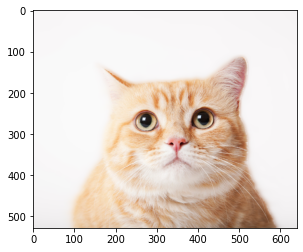

In [44]:
img_concat = np.where(img_mask_color == 255, img_orig, img_bg_blur)

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

- 고양이는 잘 잡힌 것으로 보입니다.

## 말

In [45]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/Horses_in_Meadow_800x.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)

(448, 800, 3)


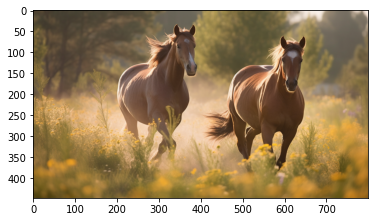

In [46]:
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)) # opencv는 BGR로 받아들이니까 plt에서 나타낼려면 RGB로 바꿔줘야합니다.
plt.show()

In [47]:
model = semantic_segmentation() 
model.load_pascalvoc_model(model_file) 
segvalues, output = model.segmentAsPascalvoc(img_path)

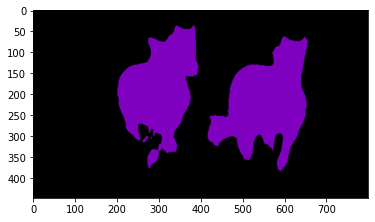

In [48]:
plt.imshow(output)
plt.show()

In [49]:
segvalues

{'class_ids': array([ 0, 13]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [51]:
colormap[13]

array([192,   0, 128])

In [54]:
seg_color = (128,0,192)

(448, 800)


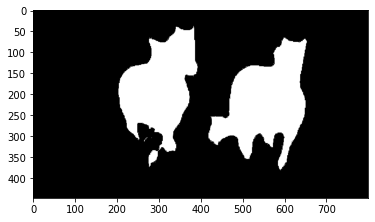

In [55]:
seg_map = np.all(output == seg_color, axis = -1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap = 'gray')
plt.show()

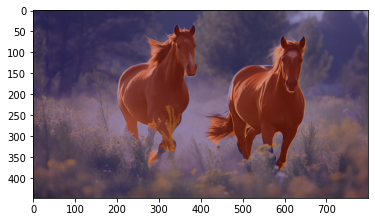

In [56]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

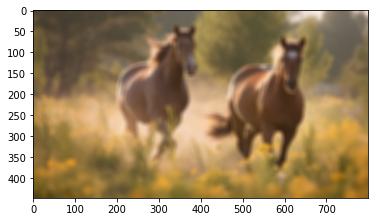

In [57]:
img_orig_blur = cv2.blur(img_orig, (13,13))

plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

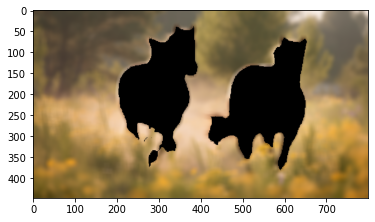

In [58]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR) 

img_bg_mask = cv2.bitwise_not(img_mask_color)

img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

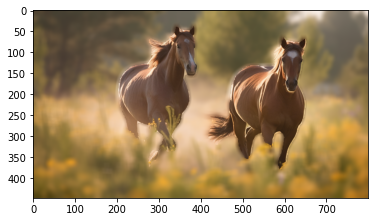

In [59]:
img_concat = np.where(img_mask_color == 255, img_orig, img_bg_blur)

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

- 왼쪽 말의 다리 부분이 살짝 이어지지 않는 것으로 보입니다.
- 이는 앞에 꽃(?)으로 보이는 것이 가리고 있어서 그런 것으로 추정됩니다.

### 인물 모드 사진의 문제점
1. 배경과의 경계가 뚜렷하게 구분되지 않습니다.
2. 겹쳐있을 때 경계가 불명확해집니다.

DeepLab V3+ 에 대한 설명 : [https://kuklife.tistory.com/121]
DeepLab V3+는 segmentation의 정확도를 높이기 위해 atrous convolution을 사용하지만, 여전히 제한된 receptive field(field of view) 내에서만 정보를 학습합니다. 이로 인해 큰 스케일의 전체적인 패턴에 대한 정보가 부족할 수 있습니다. 따라서 Transformer 구조에 기반을 둔 Segment Anything Model(SAM), BEiT(Bert Pre-Training of Image Transformers), Swin Transformer와 같은 모델을 사용하는 것이 효과적일 수 있습니다. 이들 모델은 Transformer 구조를 기반으로 하여 전역적 문맥 정보를 학습하며, 더 정확한 경계와 복잡한 패턴을 잘 파악할 수 있을 것으로 기대됩니다.